# Modified from https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Anomaly%20Detection.ipynb

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
from pmdarima import auto_arima


# Catfish Sales Data

In [64]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [65]:
#read data
catfish_sales = pd.read_csv('data/catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)

C:\Users\salmank\AppData\Local\Temp\ipykernel_18344\3461106580.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales = pd.read_csv('data/catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)


In [66]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [67]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

# Introduce an Anomaly

In [69]:
lim_catfish_sales.loc(axis=0)[datetime(1998,12,1)]  = 10000

C:\Users\salmank\AppData\Local\Temp\ipykernel_18344\2393128218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lim_catfish_sales.loc(axis=0)[datetime(1998,12,1)]  = 10000


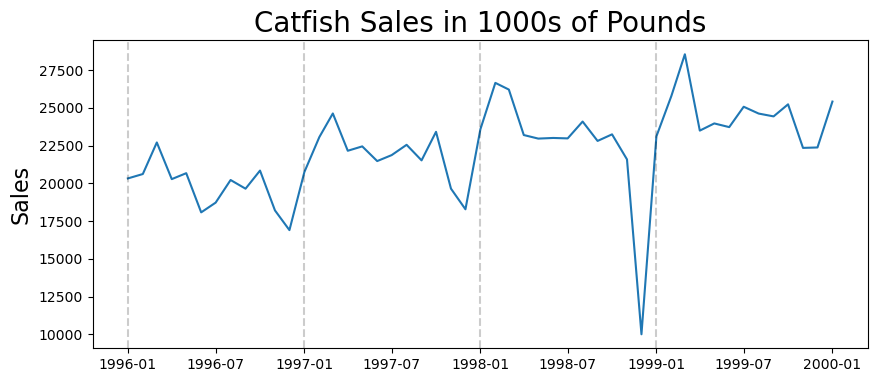

In [70]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [71]:
first_diff = lim_catfish_sales.diff()[1:]

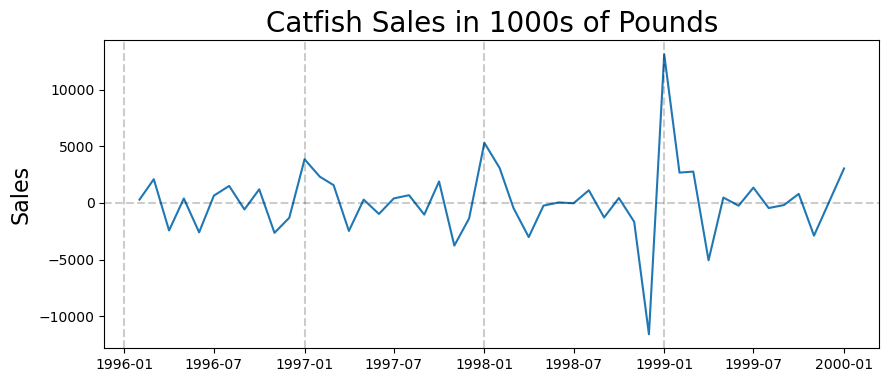

In [73]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# Get training and testing sets

In [76]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = lim_catfish_sales[train_end:test_end]
test_data

,Total
Date,
1999-07-01,25069
1999-08-01,24618
1999-09-01,24430
1999-10-01,25229
1999-11-01,22344
1999-12-01,22372
2000-01-01,25412


# Make Predictions

In [77]:
# Select order of model
train_data = lim_catfish_sales[:train_end]

Sarimax_model = auto_arima(train_data,
                       start_P=1,
                       start_q=1,
                       max_p=5,
                       max_q=5,
                       m=12,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
Sarimax_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=569.852, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=564.093, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=565.704, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=566.274, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=571.843, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=564.688, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=564.324, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=565.555, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=565.952, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=566.185, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=567.859, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.602 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   43
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -280.047
Date:                  Tue, 02 Jul 2024   AIC                            564.093
Time:                          18:05:56   BIC                            566.961
Sample:                      01-01-1996   HQIC                           565.028
                           - 07-01-1999                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1232.5161    670.403      1.838      0.066     -81.450    2546.482
sigma2      4.113e+06   7.06e+05      5.823      0.000    2.73e+06     5.5e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):               266.33
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               6.87   Skew:                            -3.23
Prob(H) (two-sided):                  0.01   Kurtosis:                        15.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
my_order = (0,1,1)
my_seasonal_order = (2, 1, [], 12)

In [79]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    #print(pred)
    rolling_predictions.loc(axis=0)[train_end] = pred.values[0]

c:\Users\salmank\anaconda3\envs\pymc_env_5\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\salmank\AppData\Local\Temp\ipykernel_18344\3135306078.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25697.9443373611' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions.loc(axis=0)[train_end] = pred.values[0]
c:\Users\salmank\anaconda3\envs\pymc_env_5\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\salmank\anaconda3\envs\pymc_env_5\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: No

In [80]:
rolling_predictions

,Total
Date,
1999-07-01,25697.944337
1999-08-01,23947.724657
1999-09-01,25016.471891
1999-10-01,23012.841401
1999-11-01,14734.228098
1999-12-01,27477.868714
2000-01-01,28843.224888


In [81]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

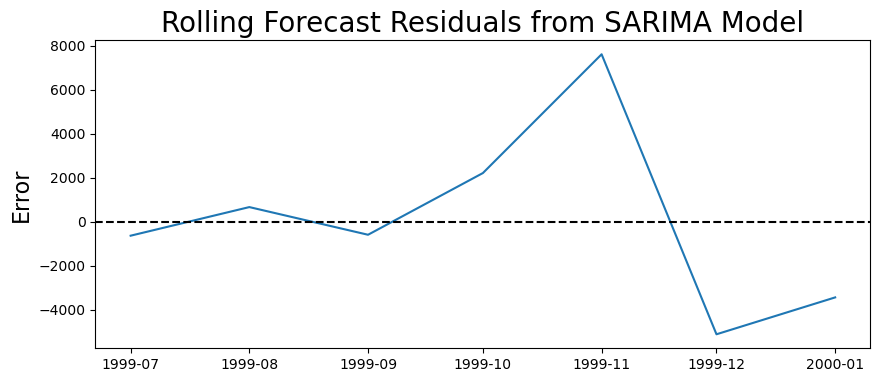

In [82]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

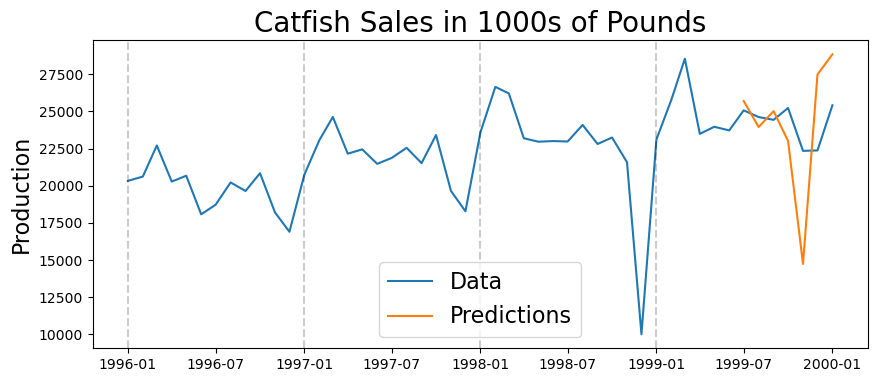

In [83]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [84]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.124


In [85]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 3814.4832297779913


# Detecting the Anomaly

## Attempt 1: Deviation Method

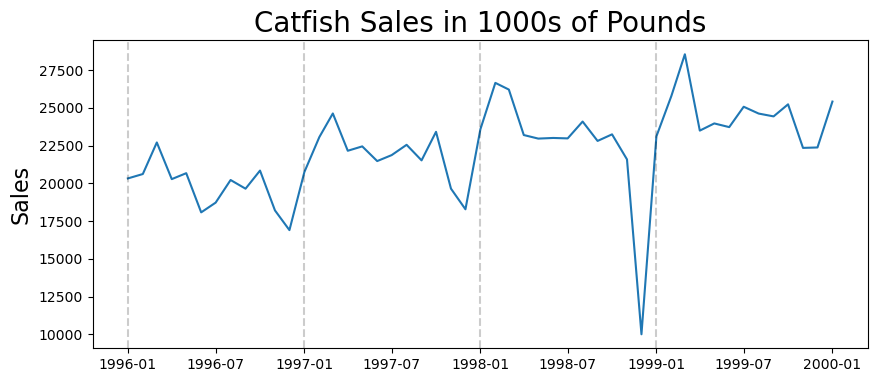

In [86]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [94]:
rolling_deviations = pd.Series(dtype=float, index = lim_catfish_sales.index)

In [95]:
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = lim_catfish_sales.loc[:date]
    
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std().values[0]


In [96]:
#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()
diff_rolling_deviations

Date
1996-03-01    1093.647565
1996-04-01    -139.611236
1996-05-01    -145.877037
1996-06-01     458.946561
1996-07-01      21.246074
1996-08-01    -110.815080
1996-09-01     -76.077319
1996-10-01     -54.778817
1996-11-01      80.512076
1996-12-01     226.024241
1997-01-01     -41.775128
1997-02-01     175.221115
1997-03-01     318.078650
1997-04-01     -17.841314
1997-05-01      -5.641973
1997-06-01     -48.435398
1997-07-01     -34.033987
1997-08-01      -5.919398
1997-09-01     -41.537143
1997-10-01      36.228047
1997-11-01     -23.461791
1997-12-01      35.514263
1998-01-01      41.376427
1998-02-01     269.009127
1998-03-01     167.204644
1998-04-01     -17.570402
1998-05-01     -24.106633
1998-06-01     -22.932892
1998-07-01     -23.339043
1998-08-01       7.472783
1998-09-01     -26.770379
1998-10-01     -18.162812
1998-11-01     -33.363392
1998-12-01     708.888216
1999-01-01     -26.914961
1999-02-01      46.648799
1999-03-01     169.912338
1999-04-01     -27.487091
1999-05

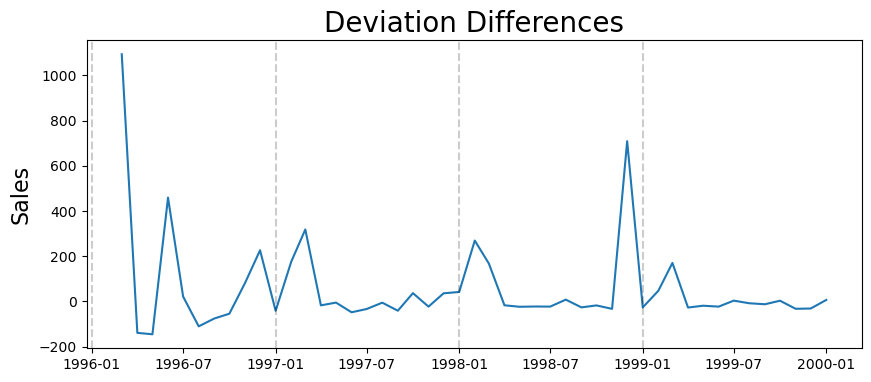

In [97]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Attempt 2: Seasonal Method

In [98]:
month_deviations = lim_catfish_sales.groupby(lambda d: d.month).std()

Text(0, 0.5, 'Sales')

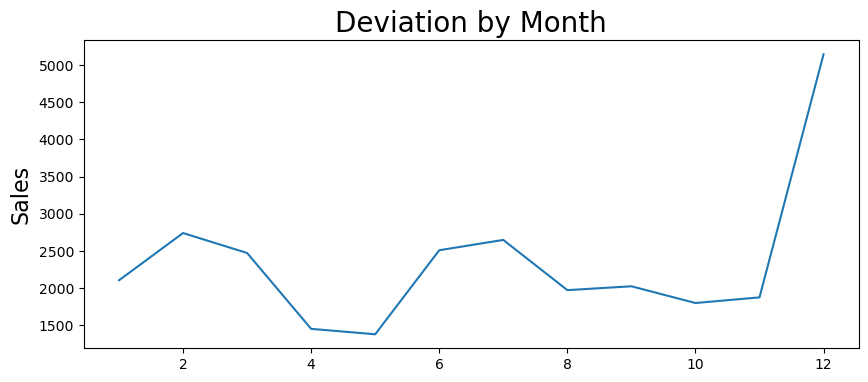

In [99]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Sales', fontsize=16)

## So, the anomaly occurs in a December

In [100]:
december_data = lim_catfish_sales[lim_catfish_sales.index.month == 12]

In [101]:
december_data

,Total
Date,
1996-12-01,16898
1997-12-01,18278
1998-12-01,10000
1999-12-01,22372


In [102]:
min_dev = 9999999
curr_anomaly = None
for date in december_data.index:
    other_data = december_data[december_data.index != date]
    curr_dev = other_data.std().values[0]
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

In [103]:
curr_anomaly

Timestamp('1998-12-01 00:00:00')

# What to do about the anomaly?

## Simple Idea: use mean of other months

In [125]:
adjusted_data = lim_catfish_sales.copy()
imputation = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()
adjusted_data.loc[curr_anomaly] = imputation.values[0]
print(imputation)
adjusted_data

Total    17588.0
dtype: float64


,Total
Date,
1996-01-01,20322
1996-02-01,20613
1996-03-01,22704
1996-04-01,20276
1996-05-01,20669
1996-06-01,18074
1996-07-01,18719
1996-08-01,20217
1996-09-01,19642


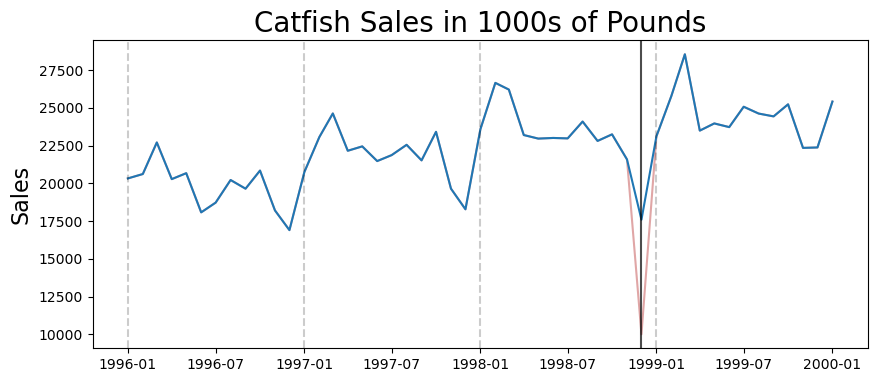

In [126]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

# Resulting Predictions

In [127]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end: test_end]
test_data

,Total
Date,
1999-07-01,25069
1999-08-01,24618
1999-09-01,24430
1999-10-01,25229
1999-11-01,22344
1999-12-01,22372
2000-01-01,25412


In [128]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data.loc(axis=0)[:train_end]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions.loc(axis=0)[train_end] = pred.values[0]
rolling_predictions

c:\Users\salmank\anaconda3\envs\pymc_env_5\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\salmank\AppData\Local\Temp\ipykernel_18344\4268156444.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25468.7435557682' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions.loc(axis=0)[train_end] = pred.values[0]
c:\Users\salmank\anaconda3\envs\pymc_env_5\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\salmank\anaconda3\envs\pymc_env_5\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: No

,Total
Date,
1999-07-01,25468.743556
1999-08-01,23873.360923
1999-09-01,24964.811857
1999-10-01,22861.022182
1999-11-01,19524.250844
1999-12-01,26207.721246
2000-01-01,28503.838157


In [129]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

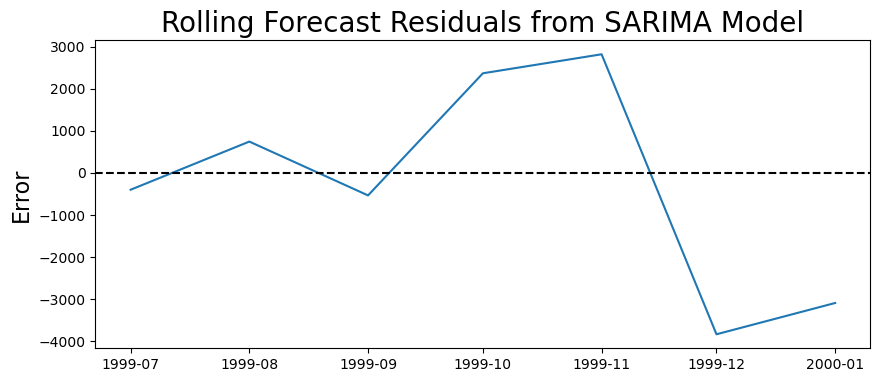

In [130]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

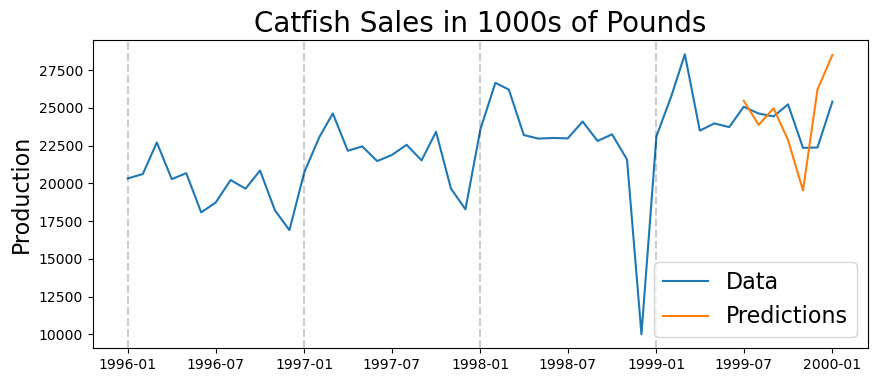

In [131]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [132]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.083


In [133]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 2355.2625242060967
